### Training of modified U-Net for Optic Disc on DRIONS-DB database, 256 px images (cross-validation fold #0).

You can either train your model or upload a pre-trained one from:
*../models_weights/05.03,02:40,U-Net light, on DRIONS-DB 256 px fold 0, SGD, high augm, CLAHE, log_dice loss/last_checkpoint.hdf5*.

In [75]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
import os
import glob
from datetime import datetime
#import warnings
#warnings.simplefilter('ignore')
import scipy as sp
import scipy.ndimage
import numpy as np
import pandas as pd
import skimage
import skimage.exposure
import mahotas as mh
from sklearn.cross_validation import KFold
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
from tqdm import tqdm_notebook
from IPython.display import display
from dual_IDG import DualImageDataGenerator

In [77]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, \
    Convolution2D, MaxPooling2D, ZeroPadding2D, Input, Embedding, LSTM, merge, \
    Lambda, UpSampling2D, Deconvolution2D, Cropping2D
from keras.utils import np_utils
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, CSVLogger
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

In [78]:
K.set_image_dim_ordering('th')

In [79]:
def mean_IOU_gpu(X, Y):
    """Computes mean Intersection-over-Union (IOU) for two arrays of binary images.
    Assuming X and Y are of shape (n_images, w, h)."""
    
    #X_fl = K.clip(K.batch_flatten(X), K.epsilon(), 1.)
    #Y_fl = K.clip(K.batch_flatten(Y), K.epsilon(), 1.)
    X_fl = K.clip(K.batch_flatten(X), 0., 1.)
    Y_fl = K.clip(K.batch_flatten(Y), 0., 1.)
    X_fl = K.cast(K.greater(X_fl, 0.5), 'float32')
    Y_fl = K.cast(K.greater(Y_fl, 0.5), 'float32')

    intersection = K.sum(X_fl * Y_fl, axis=1)
    union = K.sum(K.maximum(X_fl, Y_fl), axis=1)
    # if union == 0, it follows that intersection == 0 => score should be 0.
    union = K.switch(K.equal(union, 0), K.ones_like(union), union)
    return K.mean(intersection / K.cast(union, 'float32'))


def mean_IOU_gpu_loss(X, Y):
    return -mean_IOU_gpu(X, Y)

In [80]:
def dice(y_true, y_pred):
    # Workaround for shape bug. For some reason y_true shape was not being set correctly
    #y_true.set_shape(y_pred.get_shape())

    # Without K.clip, K.sum() behaves differently when compared to np.count_nonzero()
    #y_true_f = K.clip(K.batch_flatten(y_true), K.epsilon(), 1.)
    #y_pred_f = K.clip(K.batch_flatten(y_pred), K.epsilon(), 1.)
    y_true_f = K.clip(K.batch_flatten(y_true), 0., 1.)
    y_pred_f = K.clip(K.batch_flatten(y_pred), 0., 1.)
    #y_pred_f = K.greater(y_pred_f, 0.5)

    intersection = 2 * K.sum(y_true_f * y_pred_f, axis=1)
    union = K.sum(y_true_f * y_true_f, axis=1) + K.sum(y_pred_f * y_pred_f, axis=1)
    return K.mean(intersection / union)


def dice_loss(y_true, y_pred):
    return -dice(y_true, y_pred)


def log_dice_loss(y_true, y_pred):
    return -K.log(dice(y_true, y_pred))


def dice_metric(y_true, y_pred):
    """An exact Dice score for binary tensors."""
    y_true_f = K.cast(K.greater(y_true, 0.5), 'float32')
    y_pred_f = K.cast(K.greater(y_pred, 0.5), 'float32')
    return dice(y_true_f, y_pred_f)

In [81]:
def tf_to_th_encoding(X):
    return np.rollaxis(X, 3, 1)


def th_to_tf_encoding(X):
    return np.rollaxis(X, 1, 4)

In [82]:
h5f = h5py.File(os.path.join(os.path.dirname(os.getcwd()), 'data', 'hdf5_datasets', 'all_data.hdf5'), 'r')
#h5f = h5py.File(os.path.join(os.path.dirname(os.getcwd()), 'data', 'hdf5_datasets', 'DRIONS_DB.hdf5'), 'r')

### U-Net architecture

<img src="../pics/u_net_arch.png" width=80%>

In [83]:
def get_unet_light(img_rows=256, img_cols=256):
    inputs = Input((3, img_rows, img_cols))
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Dropout(0.3)(conv1)
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Dropout(0.3)(conv2)
    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Dropout(0.3)(conv3)
    conv3 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Dropout(0.3)(conv4)
    conv4 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool4)
    conv5 = Dropout(0.3)(conv5)
    conv5 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv5)

    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)
    conv6 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up6)
    conv6 = Dropout(0.3)(conv6)
    conv6 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
    conv7 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up7)
    conv7 = Dropout(0.3)(conv7)
    conv7 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv7)

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up8)
    conv8 = Dropout(0.3)(conv8)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up9)
    conv9 = Dropout(0.3)(conv9)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv9)

    conv10 = Convolution2D(1, 1, 1, activation='sigmoid', border_mode='same')(conv9)
    #conv10 = Flatten()(conv10)

    model = Model(input=inputs, output=conv10)

    return model

In [84]:
model = get_unet_light(img_rows=256, img_cols=256)
model.compile(optimizer=SGD(lr=3e-4, momentum=0.95),
              loss=log_dice_loss,
              metrics=[mean_IOU_gpu, dice_metric])

model.summary()

/home/artem/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu")`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/artem/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu")`
  """
/home/artem/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", activation="relu")`
  
/home/artem/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", activation="relu")`
  # Remove the CWD from sys.path while we load stuff.
/home/artem/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: UserWarning: 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 3, 256, 256)  0                                            
__________________________________________________________________________________________________
conv2d_115 (Conv2D)             (None, 32, 256, 256) 896         input_7[0][0]                    
__________________________________________________________________________________________________
dropout_55 (Dropout)            (None, 32, 256, 256) 0           conv2d_115[0][0]                 
__________________________________________________________________________________________________
conv2d_116 (Conv2D)             (None, 32, 256, 256) 9248        dropout_55[0][0]                 
__________________________________________________________________________________________________
max_poolin

/home/artem/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:47: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(1, (1, 1), padding="same", activation="sigmoid")`
/home/artem/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:50: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=Tensor("in...)`


#### DRIONS-DB

Accessing data, preparing train/validation sets division:

In [85]:
X = h5f['DRIONS-DB/256 px/images']
Y = h5f['DRIONS-DB/256 px/disc']

In [86]:
X, Y

(<HDF5 dataset "images": shape (110, 256, 256, 3), type "|u1">,
 <HDF5 dataset "disc": shape (110, 256, 256, 1), type "|u1">)

In [87]:
train_idx_cv, test_idx_cv = [], []

for _train_idx, _test_idx in KFold(len(X), n_folds=5, random_state=1):
    print(_train_idx, _test_idx)
    train_idx_cv.append(_train_idx)
    test_idx_cv.append(_test_idx)

(array([ 22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,
        35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,
        48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,
        61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
        74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,
        87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,
       100, 101, 102, 103, 104, 105, 106, 107, 108, 109]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21]))
(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  44,  45,  46,  47,
        48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,
        61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
        74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,
        87,  88,  89,  90,  91,  92,  93,  

In [88]:
#train_idx = h5f['RIM-ONE v3/train_idx_driu']
#test_idx = h5f['RIM-ONE v3/test_idx_driu']

train_idx = train_idx_cv[0]
test_idx = test_idx_cv[0]

In [89]:
len(X), len(train_idx), len(test_idx)

(110, 88, 22)

#### Generator of augmented data:

In [90]:
train_idg = DualImageDataGenerator(#rescale=1/255.0,
                                   #samplewise_center=True, samplewise_std_normalization=True,
                                   horizontal_flip=True, vertical_flip=True,
                                   rotation_range=50, width_shift_range=0.15, height_shift_range=0.15,
                                   zoom_range=(0.7, 1.3),
                                   fill_mode='constant', cval=0.0)
test_idg = DualImageDataGenerator()

#### Preprocessing function and data generator:

In [91]:
def preprocess(batch_X, batch_y, train_or_test='train'):
    batch_X = batch_X / 255.0
    batch_y = batch_y / 255.0
    if train_or_test == 'train':
        batch_X, batch_y = train_idg.flow(batch_X, batch_y, batch_size=len(batch_X), shuffle=False).next()
    elif train_or_test == 'test':
        batch_X, batch_y = test_idg.flow(batch_X, batch_y, batch_size=len(batch_X), shuffle=False).next()
    batch_X = th_to_tf_encoding(batch_X)
    batch_X = [skimage.exposure.equalize_adapthist(batch_X[i]) 
               for i in range(len(batch_X))]
    batch_X = np.array(batch_X)
    batch_X = tf_to_th_encoding(batch_X)
    return batch_X, batch_y


def data_generator(X, y, train_or_test='train', batch_size=3, return_orig=False, stationary=False):
    while True:
        if train_or_test == 'train':
            idx = np.random.choice(train_idx, size=batch_size)
        elif train_or_test == 'test':
            if stationary:
                idx = test_idx[:batch_size]
            else:
                idx = np.random.choice(test_idx, size=batch_size)
        batch_X = [X[i] for i in idx]
        batch_X = np.array(batch_X).copy()
        batch_y = [y[i] for i in idx]
        batch_y = np.array(batch_y).copy()
        batch_X = tf_to_th_encoding(batch_X)
        batch_y = tf_to_th_encoding(batch_y)
        if return_orig:
            batch_X_orig, batch_Y_orig = batch_X.copy(), batch_y.copy()
        
        batch_X, batch_y = preprocess(batch_X, batch_y, train_or_test)
        
        if not return_orig:
            yield batch_X, batch_y
        else:
            yield batch_X, batch_y, batch_X_orig, batch_Y_orig

Testing the data generator and generator for augmented data:

In [92]:
gen = data_generator(X, Y, 'train', batch_size=1)
batch = gen.next()
batch[0].shape

(1, 3, 256, 256)

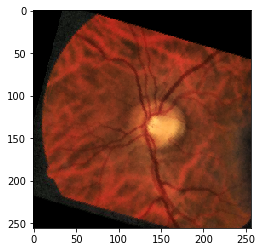

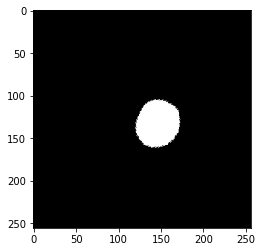

In [93]:
fig = plt.imshow(np.rollaxis(batch[0][0], 0, 3))
#plt.colorbar(mappable=fig)
plt.show()
plt.imshow(batch[1][0][0], cmap=plt.cm.Greys_r); plt.show()

In [94]:
arch_name = "U-Net light, on DRIONS-DB 256 px fold 0, SGD, high augm, CLAHE, log_dice loss"
weights_folder = os.path.join(os.path.dirname(os.getcwd()), 'models_weights',
                              '{},{}'.format(datetime.now().strftime('%d.%m,%H:%M'), arch_name))

In [95]:
weights_folder

'../models_weights/02.01,15:27,U-Net light, on DRIONS-DB 256 px fold 0, SGD, high augm, CLAHE, log_dice loss/'

In [96]:
def folder(folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    return folder_name

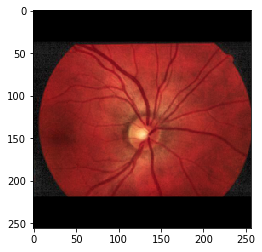

((22, 3, 256, 256), (22, 1, 256, 256))


In [97]:
X_valid, Y_valid = data_generator(X, Y, train_or_test='test', batch_size=100, stationary=True).next()
plt.imshow(np.rollaxis(X_valid[0], 0, 3)); plt.show()
print(X_valid.shape, Y_valid.shape)

### Training

If a pretrained model needs to be used, first run "Loading model" section below and then go the "Comprehensive visual check", skipping this section.

In [ ]:
history = model.fit_generator(data_generator(X, Y, train_or_test='train', batch_size=1), 
                              samples_per_epoch=99,
                              max_q_size=1,
                              
                              validation_data=(X_valid, Y_valid),
                              #validation_data=data_generator(X, Y, train_or_test='test', batch_size=1),
                              #nb_val_samples=100,
                              
                              nb_epoch=500, verbose=1,
                              
                              callbacks=[CSVLogger(os.path.join(folder(weights_folder), 'training_log.csv')),
                                         #ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.5, verbose=1, patience=40),
                                         ModelCheckpoint(os.path.join(folder(weights_folder),
                                               #'weights.ep-{epoch:02d}-val_mean_IOU-{val_mean_IOU_gpu:.2f}_val_loss_{val_loss:.2f}.hdf5',
                                               'last_checkpoint.hdf5'),
                                               monitor='val_loss', mode='min', save_best_only=True, 
                                               save_weights_only=False, verbose=0)])

### Comprehensive visual check

image #0


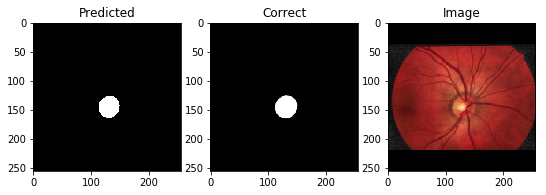

IOU: 0.922165811062
Dice: 0.969708791103
image #1


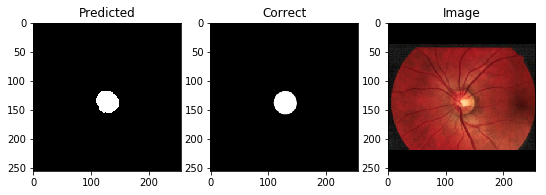

IOU: 0.858555138111
Dice: 0.93186971243
image #2


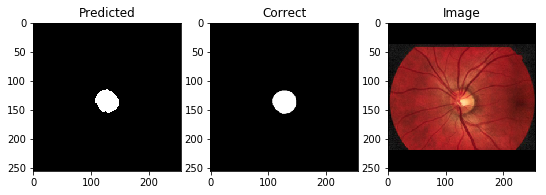

IOU: 0.879400730133
Dice: 0.947132754457
image #3


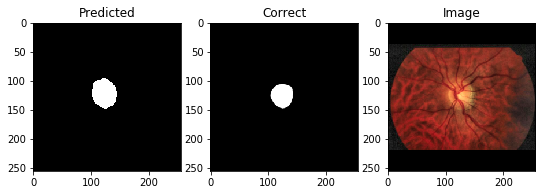

IOU: 0.71266323328
Dice: 0.839664325872
image #4


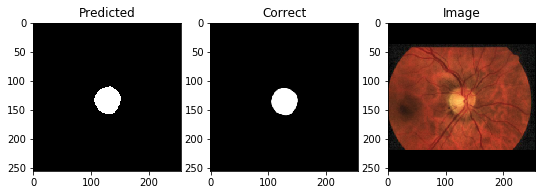

IOU: 0.889960289001
Dice: 0.949738728468
image #5


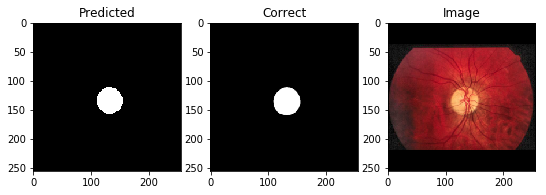

IOU: 0.907553553581
Dice: 0.958236271263
image #6


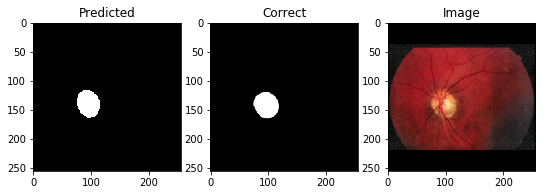

IOU: 0.845079004765
Dice: 0.924877803254
image #7


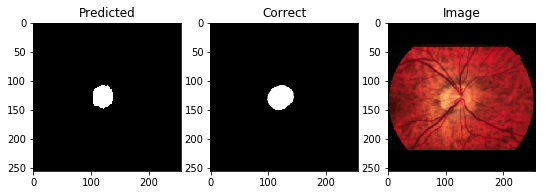

IOU: 0.759595930576
Dice: 0.871710311786
image #8


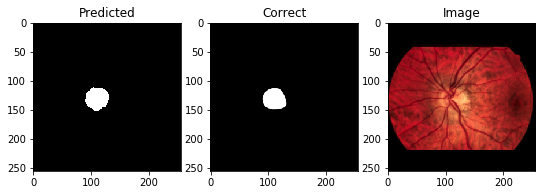

IOU: 0.849775791168
Dice: 0.927264096122
image #9


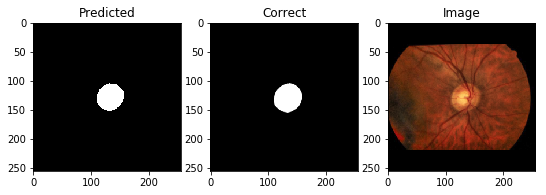

IOU: 0.881250023842
Dice: 0.947255571138
image #10


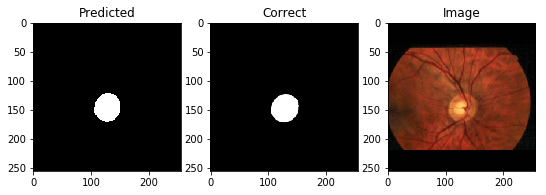

IOU: 0.895987331867
Dice: 0.952357565917
image #11


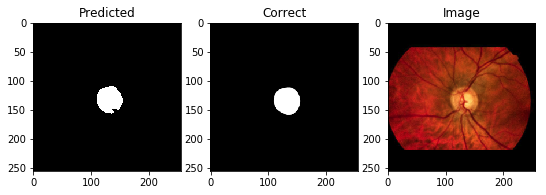

IOU: 0.863151967525
Dice: 0.936336031309
image #12


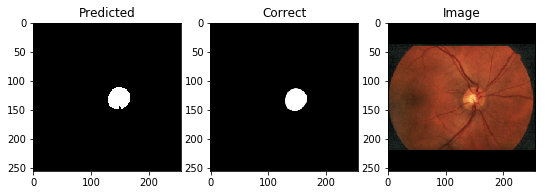

IOU: 0.839903473854
Dice: 0.920870545963
image #13


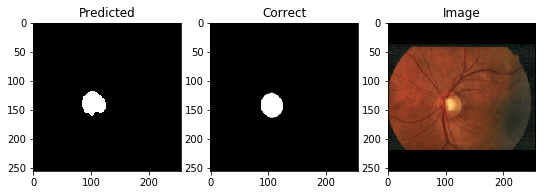

IOU: 0.759589016438
Dice: 0.87353121096
image #14


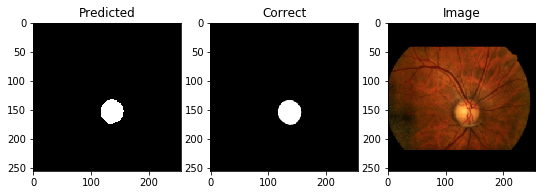

IOU: 0.901367902756
Dice: 0.956010014988
image #15


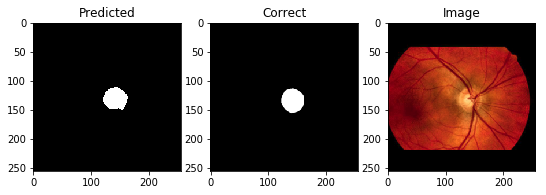

IOU: 0.801681876183
Dice: 0.898200430668
image #16


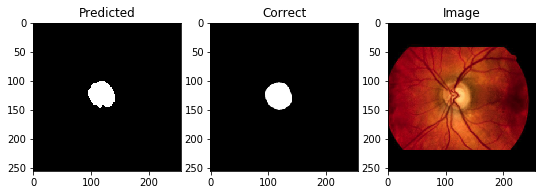

IOU: 0.877481579781
Dice: 0.942003544866
image #17


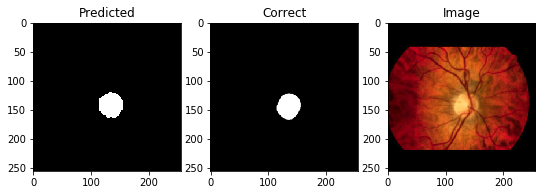

IOU: 0.861093223095
Dice: 0.935338468492
image #18


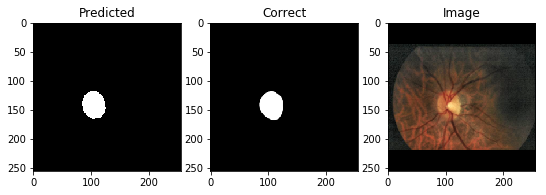

IOU: 0.906919777393
Dice: 0.958354815085
image #19


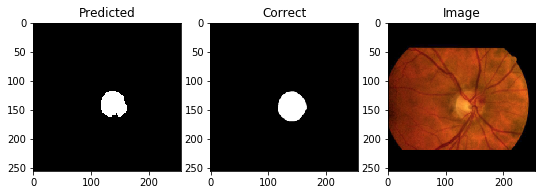

IOU: 0.744368255138
Dice: 0.862201372006
image #20


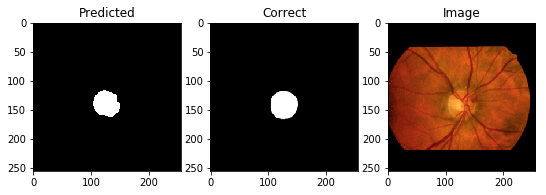

IOU: 0.838453412056
Dice: 0.919629031068
image #21


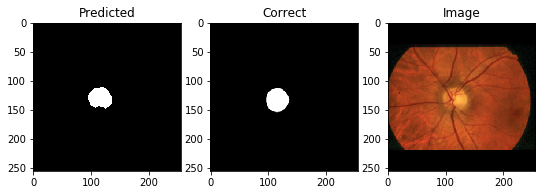

IOU: 0.794871807098
Dice: 0.894591593377


In [99]:
pred_iou, pred_dice = [], []

if K.backend() == 'tensorflow':
    sess = K.get_session()

for i, img_no in enumerate(test_idx):
    print('image #{}'.format(img_no))
    img = X[img_no]
    batch_X = X_valid[i:i + 1]
    batch_y = Y_valid[i:i + 1]
    
    pred = (model.predict(batch_X)[0, 0] > 0.5).astype(np.float64)
    #corr = Y[img_no][..., 0]
    corr = th_to_tf_encoding(batch_y)[0, ..., 0]
    
    # mean filtering:
    #pred = mh.mean_filter(pred, Bc=mh.disk(10)) > 0.5
    
    fig = plt.figure(figsize=(9, 4))
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(pred, cmap=plt.cm.Greys_r)
    ax.set_title('Predicted')
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(corr, cmap=plt.cm.Greys_r)
    ax.set_title('Correct')
    ax = fig.add_subplot(1, 3, 3)
    #ax.imshow(img)
    ax.imshow(th_to_tf_encoding(batch_X)[0])
    ax.set_title('Image')
    plt.show()
    
    if K.backend() == 'tensorflow':
        cur_iou = mean_IOU_gpu(pred[None, None, ...], corr[None, None, ...]).eval(session=sess)
        cur_dice = dice(pred[None, None, ...], corr[None, None, ...]).eval(session=sess)
    else:
        cur_iou = mean_IOU_gpu(pred[None, None, ...], corr[None, None, ...]).eval()
        cur_dice = dice(pred[None, None, ...], corr[None, None, ...]).eval()
    print('IOU: {}\nDice: {}'.format(cur_iou, cur_dice))
    pred_iou.append(cur_iou)
    pred_dice.append(cur_dice)

Acquiring scores for the validation set:

In [100]:
print(np.mean(pred_iou))
print(np.mean(pred_dice))

0.84504
0.923494681391


Showing the best and the worst cases:

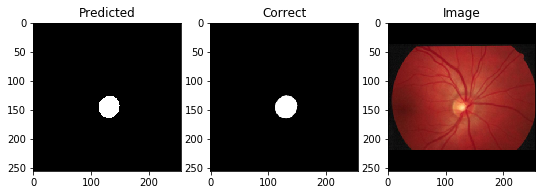

IOU: 0.922165811062 (best)


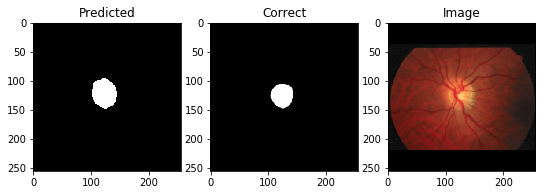

IOU: 0.71266323328 (worst)


In [101]:
def show_img_pred_corr(i, file_suffix):    # i is index of image in test_idx
    img_no = test_idx[i]
    batch_X = X[img_no:img_no + 1]
    batch_X = tf_to_th_encoding(batch_X)
    batch_y = Y[img_no:img_no + 1]
    batch_y = tf_to_th_encoding(batch_y)
    batch_X, batch_y = preprocess(batch_X, batch_y, 'test')
    
    pred = model.predict(batch_X)[0, 0] > 0.5
    #corr = Y[img_no][..., 0]
    corr = th_to_tf_encoding(batch_y)[0, ..., 0]
    
    fig = plt.figure(figsize=(9, 4))
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(pred, cmap=plt.cm.Greys_r)
    ax.set_title('Predicted')
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(corr, cmap=plt.cm.Greys_r)
    ax.set_title('Correct')
    ax = fig.add_subplot(1, 3, 3)
    #ax.imshow(img)
    ax.imshow(X[img_no])
    ax.set_title('Image')
    plt.show()
    
    plt.imsave('drions_db_fold_0_{}_case_image.png'.format(file_suffix), X[img_no])
    plt.imsave('drions_db_fold_0_{}_case_pred.png'.format(file_suffix), pred, cmap=plt.cm.Greys_r)
    plt.imsave('drions_db_fold_0_{}_case_corr.png'.format(file_suffix), corr, cmap=plt.cm.Greys_r)


best_idx = np.argmax(pred_iou)
worst_idx = np.argmin(pred_iou)
show_img_pred_corr(best_idx, 'best')
print('IOU: {} (best)'.format(pred_iou[best_idx]))
show_img_pred_corr(worst_idx, 'worst')
print('IOU: {} (worst)'.format(pred_iou[worst_idx]))

### Loading model

In [98]:
load_model = True   # lock
if not load_model:
    print('load_model == False')
else:
    # specify file:
    #model_path = '../models_weights/01.11,22:38,U-Net on DRIONS-DB 256 px, Adam, augm, log_dice loss/' \
    #    'weights.ep-20-val_mean_IOU-0.81_val_loss_0.08.hdf5'
    
    # or get the most recently altered file in a folder:
    model_folder = os.path.join(os.path.dirname(os.getcwd()), 'models_weights', '05.03,02_40,U-Net light, on DRIONS-DB 256 px fold 0, SGD, high augm, CLAHE, log_dice loss')
    
    model_path = max(glob.glob(os.path.join(model_folder, '*.hdf5')), key=os.path.getctime)
    if load_model and not os.path.exists(model_path):
        raise Exception('`model_path` does not exist')
    print('Loading weights from', model_path)

    if load_model:
        #with open(model_path + ' arch.json') as arch_file:
        #    json_string = arch_file.read()
        #new_model = model_from_json(json_string)
        model.load_weights(model_path)
    
    # Reading log statistics
    import pandas as pd
    
    log_path = os.path.join(model_folder, 'training_log.csv')
    if os.path.exists(log_path):
        log = pd.read_csv(log_path)
        if log['epoch'].dtype != 'int64':
            log = log.loc[log.epoch != 'epoch']
        print('\nmax val mean IOU: {}, at row:'.format(log['val_mean_IOU_gpu'].max()))
        print(log.loc[log['val_mean_IOU_gpu'].argmax()])
        if 'val_dice_metric' in log.columns:
            print('\n' + 'max val dice_metric: {}, at row:'.format(log['val_dice_metric'].max()))
            print(log.loc[log['val_dice_metric'].argmax()])
        if 'val_dice' in log.columns:
            print('\n' + 'max val dice: {}, at row:'.format(log['val_dice'].max()))
            print(log.loc[log['val_dice'].argmax()])

('Loading weights from', '../models_weights/05.03,02_40,U-Net light, on DRIONS-DB 256 px fold 0, SGD, high augm, CLAHE, log_dice loss/last_checkpoint.hdf5')

max val mean IOU: 0.880520782687, at row:
epoch               425.000000
dice_metric           0.926287
loss                  0.049244
mean_IOU_gpu          0.864465
val_dice_metric       0.935773
val_loss              0.040953
val_mean_IOU_gpu      0.880521
Name: 425, dtype: float64

max val dice_metric: 0.935773307627, at row:
epoch               425.000000
dice_metric           0.926287
loss                  0.049244
mean_IOU_gpu          0.864465
val_dice_metric       0.935773
val_loss              0.040953
val_mean_IOU_gpu      0.880521
Name: 425, dtype: float64
